In [ ]:
# Copyright 2023 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# **Building AI-powered data-driven applications using pgvector, LangChain and LLMs**

---

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/GoogleCloudPlatform/python-docs-samples/blob/main/cloud-sql/postgres/pgvector/notebooks/pgvector_gen_ai_demo.ipynb)

This hands-on tutorial will show you how you can add generative AI features to your own applications with just a few lines of code using pgvector, LangChain and LLMs on Google Cloud.

We will build together a sample Python application that will be able to understand and respond to human language queries about the relational data stored in your PostgreSQL database. In fact, we will further push the creative limits of the application by teaching it to generate new content based on our existing dataset.


## Objective

After completing the steps in this notebook:
- You will have a good understanding of how to use the [pgvector extension](https://github.com/pgvector/pgvector) to store and search vector embeddings in PostgreSQL. Learn more about [vector embeddings](https://cloud.google.com/blog/topics/developers-practitioners/meet-ais-multitool-vector-embeddings).
- You will get a hands-on experience with using the open-source [LangChain framework](https://python.langchain.com/en/latest/index.html) to develop applications powered by large language models. LangChain makes it easier to develop and deploy applications against any LLM model in a vendor-agnostic manner.
- You will learn about the powerful features in [Google PaLM models made available through Vertex AI](https://cloud.google.com/vertex-ai/docs/generative-ai/learn/overview).


## Example Scenario

This notebook uses an example of an e-commerce company that runs an online marketplace for buying and selling children toys. This company wants to add new generative AI experiences in their e-commerce applications for both buyers and sellers on their platform.

The goals are:

- (_Usecase 1_) For buyers: Build a new AI-powered hybrid search, where users can describe their needs in simple English text, along with regular filters (like price, etc.)
- (_Usecase 2_) For sellers: Add a new AI-powered content generation feature, where sellers will get auto-generated item description suggestions for new products that they want to add to the platform.


Dataset:
- The dataset for this notebook has been sampled and created from a larger public retail dataset available at [Kaggle](https://www.kaggle.com/datasets/promptcloud/walmart-product-details-2020). The sampled dataset used in this notebook has only about 800 toy products, while the public dataset has over 370,000 products in different categories.

## Overview of the steps

1. Download the dataset and load it into a PostgreSQL table called `products`.
   This table has 4 fields: `product_id`, `product_name`, `description`, `list_price`.
2. Split the long `description` field values into smaller chunks and generate
   vector embeddings for each chunk. The vector embeddings are then stored in another PostgreSQL table called `product_embeddings` using the `pgvector` extension. The `product_embeddings` table has a foreign key referencing the `products` table.
3. For a given user query, generate its vector embeddings and use `pgvector`
   vector similarity search operators to find closest matching products _after applying the relevant SQL filters._
4. Once matching products and their descriptions are found, use the [MapReduceChain](https://python.langchain.com/docs/modules/chains/document/map_reduce) from LangChain framework to generate a summarized high-quality context using an LLM model (Google PaLM in this case).
5. Finally, pass the context to an LLM prompt to answer the user query. The LLM
   model will return a well-formatted natural sounding English result back to
   the user.

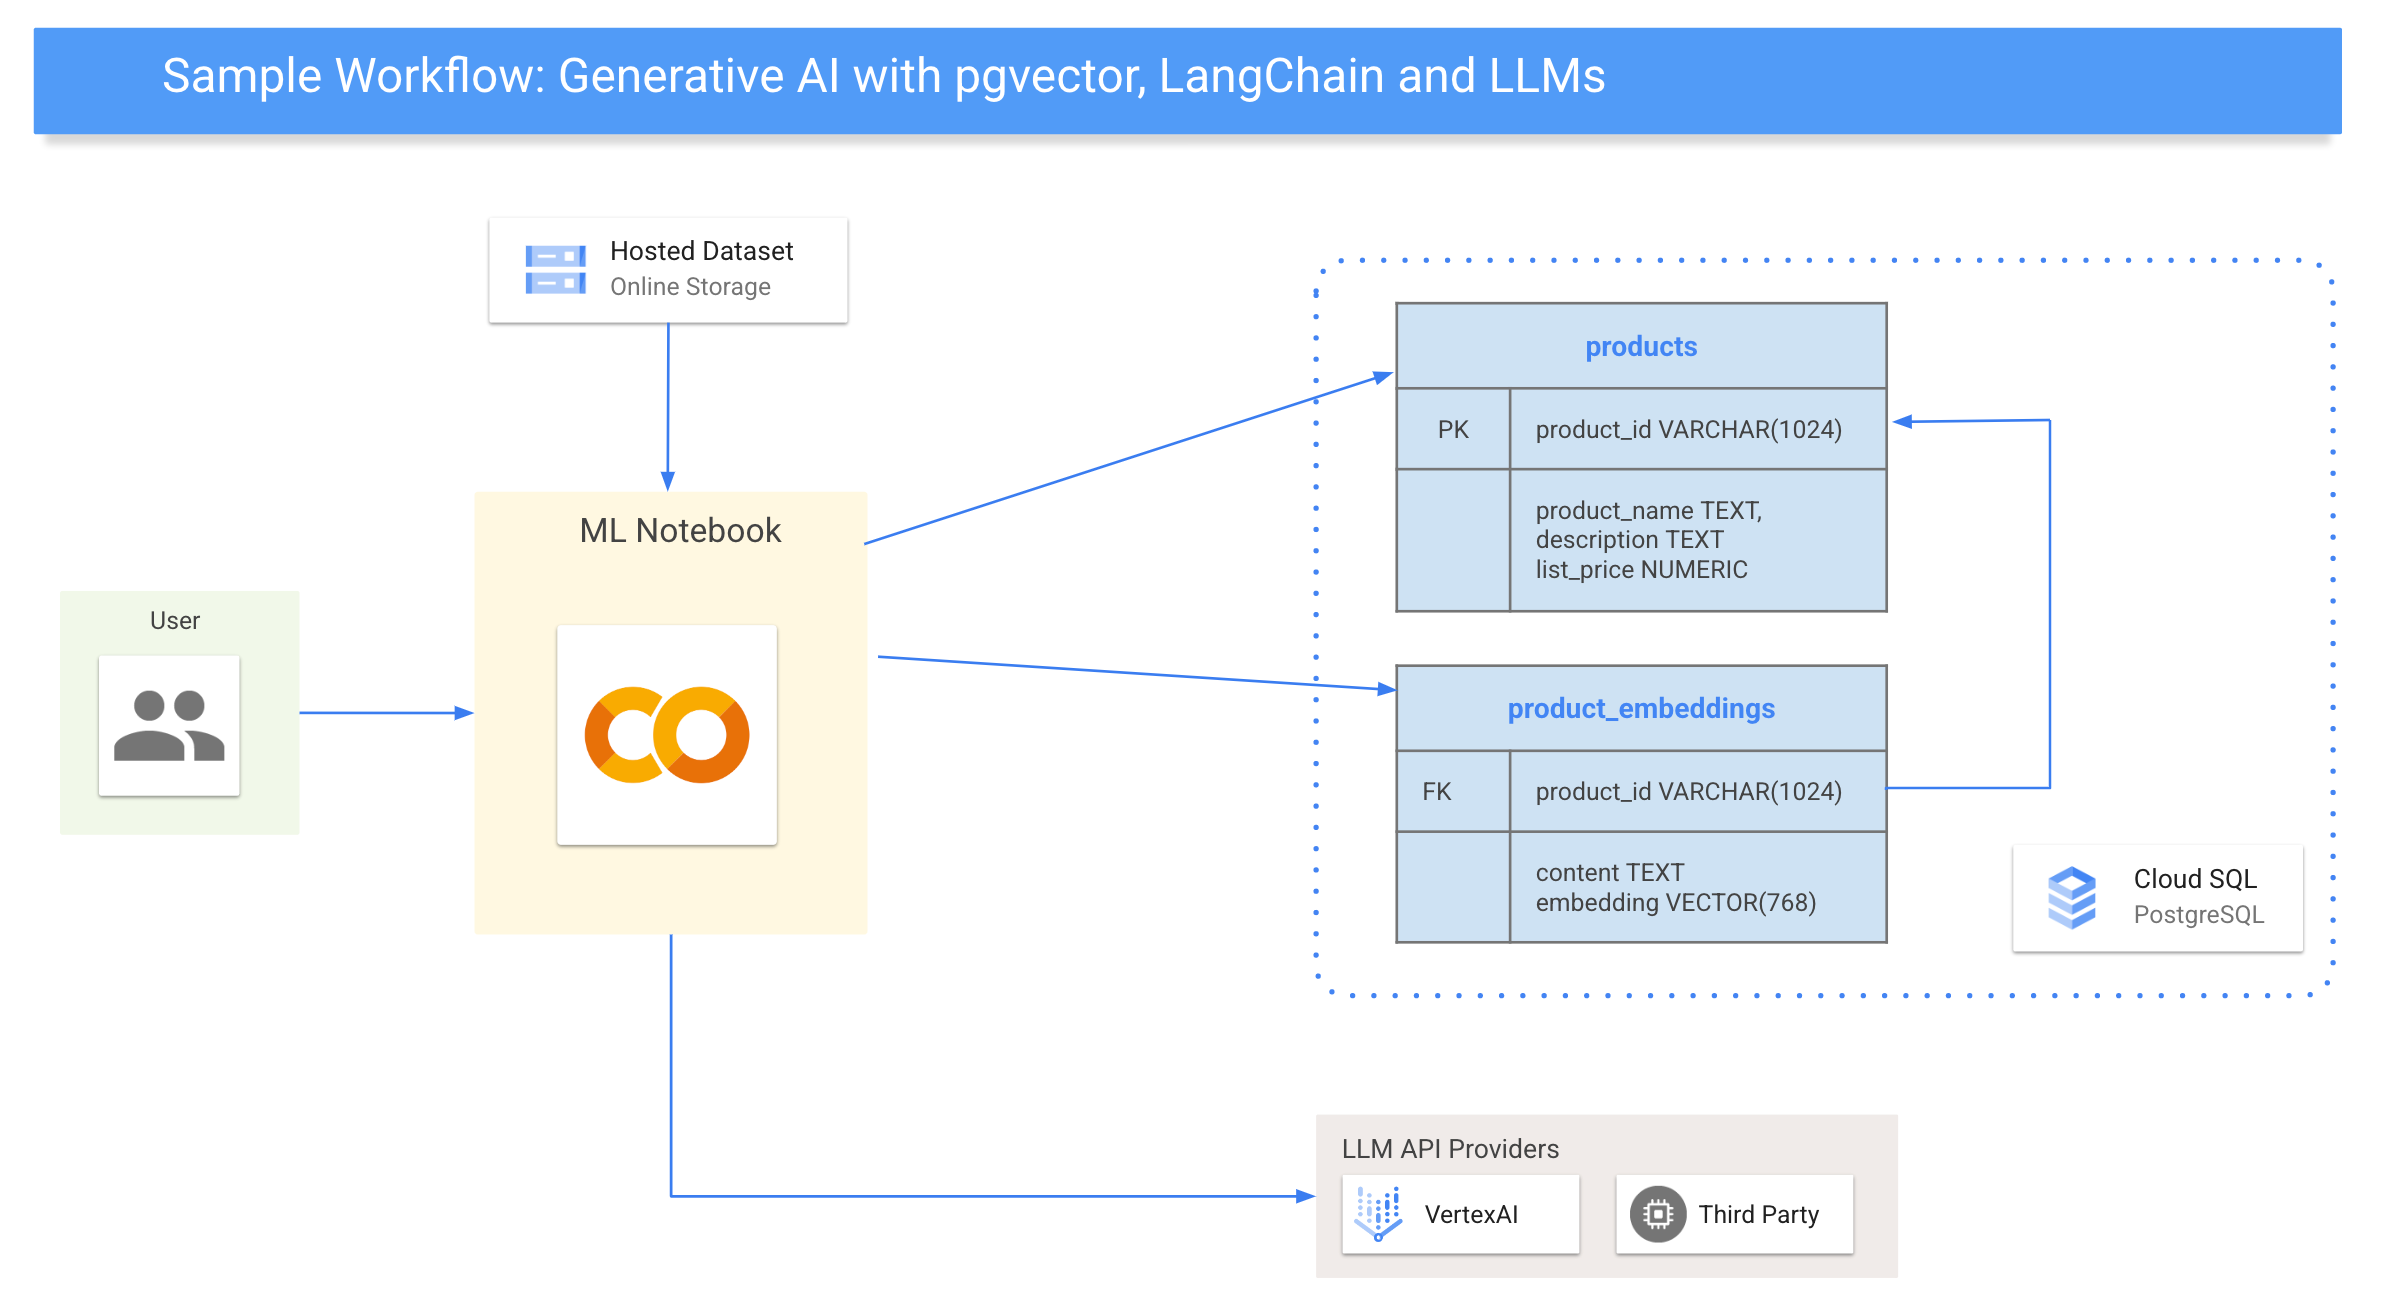

Let's dive in!

---

&nbsp;
&nbsp;
&nbsp;

## Before you begin

>⚠️ **Running this codelab will incur Google Cloud charges. You may also be billed for Vertex AI API usages.**

Pre-requisities:
- You need to have an active Google Cloud account to successfully complete this tutorial.
-  This sample notebook must be connected to a **Google Cloud project**, but nothing else is needed other than your Google Cloud project.
- You can use an existing project. Alternatively, you can create a new Cloud project [with free trial cloud credits.](https://cloud.google.com/free/docs/gcp-free-tier)
- You can use an existing Cloud SQL PostgreSQL instance for this tutorial. If an existing instance is not found, this tutorial will automatically create one for you.
- Note that this notebook connects to the Cloud SQL instance via public IP using the [Cloud SQL Python connector](https://cloud.google.com/blog/topics/developers-practitioners/how-connect-cloud-sql-using-python-easy-way). Therefore, your Cloud SQL instance should have a public IP assigned to it.
- At the end of the tutorial, you can optionally clean-up these resources to avoid further charges.


### Using this interactive notebook

Click the **run** icon on the top left corner ▶️  of each cell within this notebook.

> 💡 Alternatively, you can run the currently selected cell with `Ctrl + Enter` (or `⌘ + Enter` on a Mac).

> ⚠️ **To avoid any errors**, wait for each cell to finish in their order before clicking the next “run” icon.

## Setup

### Install required packages

>⚠️ You may receive a warning to "Restart Runtime" after the packages are installed. Don't worry, the subsequent cells will help you restart the runtime.

In [ ]:
# Install dependencies.
!pip install asyncio==3.4.3 asyncpg==0.27.0 cloud-sql-python-connector["asyncpg"]==1.2.3
!pip install numpy==1.22.4 pandas==1.5.3
!pip install pgvector==0.1.8
!pip install langchain==0.0.196 transformers==4.30.1
!pip install google-cloud-aiplatform==1.26.0

In [ ]:
# Automatically restart kernel after installs so that your environment
# can access the new packages.
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

### Setup Google Cloud environment

>⚠️ Please fill in your **Google Cloud project ID** and a new **password** for your Cloud SQL PostgreSQL database.

In [ ]:
# @markdown Replace the required placeholder text below. You can modify any other default values, if you like.

# Please fill in these values.
project_id = "[YOUR_PROJECT_ID  **REQUIRED**]"  # @param {type:"string"}
database_password = "[YOUR_PASSWORD  **REQUIRED**]"  # @param {type:"string"}
region = "us-west2"  # @param {type:"string"}
instance_name = "pg15-pgvector-demo"  # @param {type:"string"}
database_name = "retail"  # @param {type:"string"}
database_user = "retail-admin"  # @param {type:"string"}


# Quick input validations.
assert project_id, "⚠️ Please provide a Google Cloud project ID"
assert region, "⚠️ Please provide a Google Cloud region"
assert instance_name, "⚠️ Please provide the name of your instance"
assert database_name, "⚠️ Please provide a database name"
assert database_user, "⚠️ Please provide a database user"
assert database_password, "⚠️ Please provide a database password"

In [ ]:
#@markdown ###Authenticate your Google Cloud Account and enable APIs.
# Authenticate gcloud.
from google.colab import auth
auth.authenticate_user()

# Configure gcloud.
!gcloud config set project {project_id}

# Grant Cloud SQL Client role to authenticated user
current_user = !gcloud auth list --filter=status:ACTIVE --format="value(account)"

!gcloud projects add-iam-policy-binding {project_id} \
  --member=user:{current_user[0]} \
  --role="roles/cloudsql.client"


# Enable Cloud SQL Admin API
!gcloud services enable sqladmin.googleapis.com
!gcloud services enable aiplatform.googleapis.com

### Setup Cloud SQL instance and PostgreSQL database

In [ ]:
#@markdown Create and setup a Cloud SQL PostgreSQL instance, if not done already.
database_version = !gcloud sql instances describe {instance_name} --format="value(databaseVersion)"
if database_version[0].startswith("POSTGRES"):
  print("Found an existing Postgres Cloud SQL Instance!")
else:
  print("Creating new Cloud SQL instance...")
  !gcloud sql instances create {instance_name} --database-version=POSTGRES_15 \
    --region={region} --cpu=1 --memory=4GB --root-password={database_password}

# Create the database, if it does not exist.
out = !gcloud sql databases list --instance={instance_name} --filter="NAME:{database_name}" --format="value(NAME)"
if ''.join(out) == database_name:
  print("Database %s already exists, skipping creation." % database_name)
else:
  !gcloud sql databases create {database_name} --instance={instance_name}

# Create the database user for accessing the database.
!gcloud sql users create {database_user} \
  --instance={instance_name} \
  --password={database_password}

In [ ]:
# @markdown Verify that you are able to connect to the database. Executing this block should print the current PostgreSQL server version.

import asyncio
import asyncpg
from google.cloud.sql.connector import Connector


async def main():
    # get current running event loop to be used with Connector
    loop = asyncio.get_running_loop()
    # initialize Connector object as async context manager
    async with Connector(loop=loop) as connector:
        # create connection to Cloud SQL database
        conn: asyncpg.Connection = await connector.connect_async(
            f"{project_id}:{region}:{instance_name}",  # Cloud SQL instance connection name
            "asyncpg",
            user=f"{database_user}",
            password=f"{database_password}",
            db=f"{database_name}"
            # ... additional database driver args
        )

        # query Cloud SQL database
        results = await conn.fetch("SELECT version()")
        print(results[0]["version"])

        # close asyncpg connection
        await conn.close()


# Test connection with `asyncio`
await main()  # type: ignore

## Prepare data

### Download and load the dataset in PostgreSQL

In [ ]:
# Load dataset from a web URL and store it in a pandas dataframe.

import pandas as pd
import os

DATASET_URL = "https://github.com/GoogleCloudPlatform/python-docs-samples/raw/main/cloud-sql/postgres/pgvector/data/retail_toy_dataset.csv"
df = pd.read_csv(DATASET_URL)
df = df.loc[:, ["product_id", "product_name", "description", "list_price"]]
df = df.dropna()
df.head(10)

In [ ]:
# Save the Pandas dataframe in a PostgreSQL table.

import asyncio
import asyncpg
from google.cloud.sql.connector import Connector


async def main():
    loop = asyncio.get_running_loop()
    async with Connector(loop=loop) as connector:
        # Create connection to Cloud SQL database
        conn: asyncpg.Connection = await connector.connect_async(
            f"{project_id}:{region}:{instance_name}",  # Cloud SQL instance connection name
            "asyncpg",
            user=f"{database_user}",
            password=f"{database_password}",
            db=f"{database_name}",
        )

        await conn.execute("DROP TABLE IF EXISTS products CASCADE")
        # Create the `products` table.
        await conn.execute(
            """CREATE TABLE products(
                                product_id VARCHAR(1024) PRIMARY KEY,
                                product_name TEXT,
                                description TEXT,
                                list_price NUMERIC)"""
        )

        # Copy the dataframe to the `products` table.
        tuples = list(df.itertuples(index=False))
        await conn.copy_records_to_table(
            "products", records=tuples, columns=list(df), timeout=10
        )
        await conn.close()


# Run the SQL commands now.
await main()  # type: ignore

## Vector Embeddings

### Generate vector embeddings using a Text Embedding model

Step 1: Split long product description text into smaller chunks

- The product descriptions can be much longer than what can fit into a single API request for generating the vector embedding.

- For example, Vertex AI text embedding model accepts a maximum of 3,072 input tokens for a single API request.

- Use the `RecursiveCharacterTextSplitter` from LangChain library to split
the description into smaller chunks of 500 characters each.

In [ ]:
# Split long text descriptions into smaller chunks that can fit into
# the API request size limit, as expected by the LLM providers.

from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    separators=[".", "\n"],
    chunk_size=500,
    chunk_overlap=0,
    length_function=len,
)
chunked = []
for index, row in df.iterrows():
    product_id = row["product_id"]
    desc = row["description"]
    splits = text_splitter.create_documents([desc])
    for s in splits:
        r = {"product_id": product_id, "content": s.page_content}
        chunked.append(r)

Step 2: Generate vector embedding for each chunk by calling an Embedding Generation service

- In this demo, Vertex AI text embedding model is used to generate vector embeddings, which outputs a 768-dimensional vector for each chunk of text.

>⚠️ The following code snippet may run for a few minutes.

In [ ]:
# Generate the vector embeddings for each chunk of text.
# This code snippet may run for a few minutes.

from langchain.embeddings import VertexAIEmbeddings
from google.cloud import aiplatform
import time

aiplatform.init(project=f"{project_id}", location=f"{region}")
embeddings_service = VertexAIEmbeddings()


# Helper function to retry failed API requests with exponential backoff.
def retry_with_backoff(func, *args, retry_delay=5, backoff_factor=2, **kwargs):
    max_attempts = 10
    retries = 0
    for i in range(max_attempts):
        try:
            return func(*args, **kwargs)
        except Exception as e:
            print(f"error: {e}")
            retries += 1
            wait = retry_delay * (backoff_factor**retries)
            print(f"Retry after waiting for {wait} seconds...")
            time.sleep(wait)


batch_size = 5
for i in range(0, len(chunked), batch_size):
    request = [x["content"] for x in chunked[i : i + batch_size]]
    response = retry_with_backoff(embeddings_service.embed_documents, request)
    # Store the retrieved vector embeddings for each chunk back.
    for x, e in zip(chunked[i : i + batch_size], response):
        x["embedding"] = e

# Store the generated embeddings in a pandas dataframe.
product_embeddings = pd.DataFrame(chunked)
product_embeddings.head()

### Use pgvector to store the generated embeddings within PostgreSQL

- The `pgvector` extension introduces a new `vector` data type.
- **The new `vector` data type allows you to directly save a vector embedding (represented as a NumPy array) through a simple INSERT statement in PostgreSQL!**

>⚠️ The following code snippet may run for a few minutes.

In [ ]:
# Store the generated vector embeddings in a PostgreSQL table.
# This code may run for a few minutes.

import asyncio
import asyncpg
from google.cloud.sql.connector import Connector
import numpy as np
from pgvector.asyncpg import register_vector


async def main():
    loop = asyncio.get_running_loop()
    async with Connector(loop=loop) as connector:
        # Create connection to Cloud SQL database.
        conn: asyncpg.Connection = await connector.connect_async(
            f"{project_id}:{region}:{instance_name}",  # Cloud SQL instance connection name
            "asyncpg",
            user=f"{database_user}",
            password=f"{database_password}",
            db=f"{database_name}",
        )

        await conn.execute("CREATE EXTENSION IF NOT EXISTS vector")
        await register_vector(conn)

        await conn.execute("DROP TABLE IF EXISTS product_embeddings")
        # Create the `product_embeddings` table to store vector embeddings.
        await conn.execute(
            """CREATE TABLE product_embeddings(
                                product_id VARCHAR(1024) NOT NULL REFERENCES products(product_id),
                                content TEXT,
                                embedding vector(768))"""
        )

        # Store all the generated embeddings back into the database.
        for index, row in product_embeddings.iterrows():
            await conn.execute(
                "INSERT INTO product_embeddings (product_id, content, embedding) VALUES ($1, $2, $3)",
                row["product_id"],
                row["content"],
                np.array(row["embedding"]),
            )

        await conn.close()


# Run the SQL commands now.
await main()  # type: ignore

### Create indexes for faster similarity search in pgvector

- Vector indexes can significantly speed up similarity search operation and avoid the brute-force exact nearest neighbor search that is used by default.

- pgvector comes with two types of indexes (as of v0.5.1): `hnsw` and `ivfflat`.

> 💡 Click [here](https://cloud.google.com/blog/products/databases/faster-similarity-search-performance-with-pgvector-indexes) to learn more about pgvector indexes.

Enter or modify the values of index parameters for your index of choice and run the corresponding cell:

In [ ]:
# @markdown Create an HNSW index on the `product_embeddings` table:
m =  24 # @param {type:"integer"}
ef_construction = 100  # @param {type:"integer"}
operator =  "vector_cosine_ops"  # @param ["vector_cosine_ops", "vector_l2_ops", "vector_ip_ops"]

# Quick input validations.
assert m, "⚠️ Please input a valid value for m."
assert ef_construction, "⚠️ Please input a valid value for ef_construction."
assert operator, "⚠️ Please input a valid value for operator."

from pgvector.asyncpg import register_vector
import asyncio
import asyncpg
from google.cloud.sql.connector import Connector


async def main():
    loop = asyncio.get_running_loop()
    async with Connector(loop=loop) as connector:
        # Create connection to Cloud SQL database.
        conn: asyncpg.Connection = await connector.connect_async(
            f"{project_id}:{region}:{instance_name}",  # Cloud SQL instance connection name
            "asyncpg",
            user=f"{database_user}",
            password=f"{database_password}",
            db=f"{database_name}",
        )

        await register_vector(conn)

        # Create an HNSW index on the `product_embeddings` table.
        await conn.execute(
            f"""CREATE INDEX ON product_embeddings
              USING hnsw(embedding {operator})
              WITH (m = {m}, ef_construction = {ef_construction})
            """
        )

        await conn.close()


# Run the SQL commands now.
await main()  # type: ignore

In [ ]:
# @markdown Create an IVFFLAT index on the `product_embeddings` table:
lists =  100 # @param {type:"integer"}
operator =  "vector_cosine_ops"  # @param ["vector_cosine_ops", "vector_l2_ops", "vector_ip_ops"]

# Quick input validations.
assert lists, "⚠️ Please input a valid value for lists."

from pgvector.asyncpg import register_vector
import asyncio
import asyncpg
from google.cloud.sql.connector import Connector


async def main():
    loop = asyncio.get_running_loop()
    async with Connector(loop=loop) as connector:
        # Create connection to Cloud SQL database.
        conn: asyncpg.Connection = await connector.connect_async(
            f"{project_id}:{region}:{instance_name}",  # Cloud SQL instance connection name
            "asyncpg",
            user=f"{database_user}",
            password=f"{database_password}",
            db=f"{database_name}",
        )

        await register_vector(conn)

        # Create an IVFFLAT index on the `product_embeddings` table.
        await conn.execute(
            f"""CREATE INDEX ON product_embeddings
              USING ivfflat(embedding {operator})
              WITH (lists = {lists})
            """
        )

        await conn.close()


# Run the SQL commands now.
await main()  # type: ignore

### Demo: Finding similar toy products using pgvector cosine search operator


In [ ]:
# @markdown Enter a short description of the toy to search for within a specified price range:
toy = "playing card games"  # @param {type:"string"}
min_price = 25  # @param {type:"integer"}
max_price = 100  # @param {type:"integer"}

# Quick input validations.
assert toy, "⚠️ Please input a valid input search text"

from langchain.embeddings import VertexAIEmbeddings
from google.cloud import aiplatform

aiplatform.init(project=f"{project_id}", location=f"{region}")

embeddings_service = VertexAIEmbeddings()
qe = embeddings_service.embed_query([toy])
from pgvector.asyncpg import register_vector
import asyncio
import asyncpg
from google.cloud.sql.connector import Connector

matches = []


async def main():
    loop = asyncio.get_running_loop()
    async with Connector(loop=loop) as connector:
        # Create connection to Cloud SQL database.
        conn: asyncpg.Connection = await connector.connect_async(
            f"{project_id}:{region}:{instance_name}",  # Cloud SQL instance connection name
            "asyncpg",
            user=f"{database_user}",
            password=f"{database_password}",
            db=f"{database_name}",
        )

        await register_vector(conn)
        similarity_threshold = 0.1
        num_matches = 50

        # Find similar products to the query using cosine similarity search
        # over all vector embeddings. This new feature is provided by `pgvector`.
        results = await conn.fetch(
            """
                            WITH vector_matches AS (
                              SELECT product_id, 1 - (embedding <=> $1) AS similarity
                              FROM product_embeddings
                              WHERE 1 - (embedding <=> $1) > $2
                              ORDER BY similarity DESC
                              LIMIT $3
                            )
                            SELECT product_name, list_price, description FROM products
                            WHERE product_id IN (SELECT product_id FROM vector_matches)
                            AND list_price >= $4 AND list_price <= $5
                            """,
            qe,
            similarity_threshold,
            num_matches,
            min_price,
            max_price,
        )

        if len(results) == 0:
            raise Exception("Did not find any results. Adjust the query parameters.")

        for r in results:
            # Collect the description for all the matched similar toy products.
            matches.append(
                {
                    "product_name": r["product_name"],
                    "description": r["description"],
                    "list_price": round(r["list_price"], 2),
                }
            )

        await conn.close()


# Run the SQL commands now.
await main()  # type: ignore

# Show the results for similar products that matched the user query.
matches = pd.DataFrame(matches)
matches.head(5)

Checkpoint:
- We have extracted the semantic knowledge of the dataset and made it searchable through pgvector and PostgreSQL.
- The demo will show next how you can use this semantic knowledge to answer complex natural language queries using LLMs.

## LLMs and LangChain

### *Use case 1*: Building an AI-curated contextual hybrid search

Combine natural language query text with regular relational filters to create a powerful hybrid search.

Example: A grandparent wants to use the **AI-powered search interface** to find an educational toy for their grandkid that fits within their budget.

In [ ]:
# @markdown Enter the user search query in a simple English text. The price filters are shown separately here for demo purposes. These filters may represent additional input from your frontend application.
# Please fill in these values.
user_query = "Do you have a beach toy set that teaches numbers and letters to kids?"  # @param {type:"string"}
min_price = 20  # @param {type:"integer"}
max_price = 100  # @param {type:"integer"}

# Quick input validations.
assert user_query, "⚠️ Please input a valid input search text"

Step 1: Generate the vector embedding for the user query

In [ ]:
qe = embeddings_service.embed_query([user_query])

Step 2: Use `pgvector` to find similar products

- The new `pgvector` similarity search operators provide powerful semantics
to combine the vector search operation with regular query filters in a single SQL query.
- **Using pgvector, you can now seamlessly integrate the power of relational databases with your vector search operations!**


In [ ]:
from pgvector.asyncpg import register_vector
import asyncio
import asyncpg
from google.cloud.sql.connector import Connector

matches = []


async def main():
    loop = asyncio.get_running_loop()
    async with Connector(loop=loop) as connector:
        # Create connection to Cloud SQL database.
        conn: asyncpg.Connection = await connector.connect_async(
            f"{project_id}:{region}:{instance_name}",  # Cloud SQL instance connection name
            "asyncpg",
            user=f"{database_user}",
            password=f"{database_password}",
            db=f"{database_name}",
        )

        await register_vector(conn)
        similarity_threshold = 0.7
        num_matches = 5

        # Find similar products to the query using cosine similarity search
        # over all vector embeddings. This new feature is provided by `pgvector`.
        results = await conn.fetch(
            """
                            WITH vector_matches AS (
                              SELECT product_id, 1 - (embedding <=> $1) AS similarity
                              FROM product_embeddings
                              WHERE 1 - (embedding <=> $1) > $2
                              ORDER BY similarity DESC
                              LIMIT $3
                            )
                            SELECT product_name, list_price, description FROM products
                            WHERE product_id IN (SELECT product_id FROM vector_matches)
                            AND list_price >= $4 AND list_price <= $5
                            """,
            qe,
            similarity_threshold,
            num_matches,
            min_price,
            max_price,
        )

        if len(results) == 0:
            raise Exception("Did not find any results. Adjust the query parameters.")

        for r in results:
            # Collect the description for all the matched similar toy products.
            matches.append(
                f"""The name of the toy is {r["product_name"]}.
                          The price of the toy is ${round(r["list_price"], 2)}.
                          Its description is below:
                          {r["description"]}."""
            )
        await conn.close()


# Run the SQL commands now.
await main()  # type: ignore

# Show the results for similar products that matched the user query.
matches

Step 3: Use LangChain to summarize and generate a high-quality prompt to answer the user query

- After finding the similar products and their descriptions using `pgvector`, the next step is to use them for generating a prompt input for the LLM model.
- Since individual product descriptions can be very long, they may not fit within the specified input payload limit for an LLM model.
- The `MapReduceChain` from LangChain framework is used to generate and combine short summaries of similarly matched products.
- The combined summaries are then used to build a high-quality prompt for an input to the LLM model.

In [ ]:
# Using LangChain for summarization and efficient context building.

from langchain.chains.summarize import load_summarize_chain
from langchain.docstore.document import Document
from langchain.llms import VertexAI
from langchain import PromptTemplate, LLMChain
from IPython.display import display, Markdown

llm = VertexAI()

map_prompt_template = """
              You will be given a detailed description of a toy product.
              This description is enclosed in triple backticks (```).
              Using this description only, extract the name of the toy,
              the price of the toy and its features.

              ```{text}```
              SUMMARY:
              """
map_prompt = PromptTemplate(template=map_prompt_template, input_variables=["text"])

combine_prompt_template = """
                You will be given a detailed description different toy products
                enclosed in triple backticks (```) and a question enclosed in
                double backticks(``).
                Select one toy that is most relevant to answer the question.
                Using that selected toy description, answer the following
                question in as much detail as possible.
                You should only use the information in the description.
                Your answer should include the name of the toy, the price of the toy
                and its features. Your answer should be less than 200 words.
                Your answer should be in Markdown in a numbered list format.


                Description:
                ```{text}```


                Question:
                ``{user_query}``


                Answer:
                """
combine_prompt = PromptTemplate(
    template=combine_prompt_template, input_variables=["text", "user_query"]
)

docs = [Document(page_content=t) for t in matches]
chain = load_summarize_chain(
    llm, chain_type="map_reduce", map_prompt=map_prompt, combine_prompt=combine_prompt
)
answer = chain.run(
    {
        "input_documents": docs,
        "user_query": user_query,
    }
)


display(Markdown(answer))

### _Use case 2_: Adding AI-powered creative content generation

Use knowledge from the existing dataset to generate new AI-powered content from an initial prompt.

Example: A third-party seller on the retail platform wants to use the **AI-powered content generation** to create a detailed description of their new bicycle product.

In [ ]:
# @markdown Describe your a new product in just a few words:
# Please fill in these values.
creative_prompt = "A bicycle with brand name 'Roadstar bike' for kids that comes with training wheels and helmet."  # @param {type:"string"}

# Quick input validations.
assert creative_prompt, "⚠️ Please input a valid input search text"

Step 1: Find an existing product description matching the initial prompt

- Leverage the `pgvector` similarity search operator to find an existing
product description that closely matches the new product specified
in the initial prompt.

In [ ]:
from pgvector.asyncpg import register_vector
import asyncio
import asyncpg
from google.cloud.sql.connector import Connector

qe = embeddings_service.embed_query([creative_prompt])
qe_str = "[%s]" % (",".join([str(x) for x in qe]))
matches = []


async def main():
    loop = asyncio.get_running_loop()
    async with Connector(loop=loop) as connector:
        # Create connection to Cloud SQL database.
        conn: asyncpg.Connection = await connector.connect_async(
            f"{project_id}:{region}:{instance_name}",  # Cloud SQL instance connection name
            "asyncpg",
            user=f"{database_user}",
            password=f"{database_password}",
            db=f"{database_name}",
        )

        await register_vector(conn)
        similarity_threshold = 0.7

        # Find similar products to the query using cosine similarity search
        # over all vector embeddings. This new feature is provided by `pgvector`.
        results = await conn.fetch(
            """
                            WITH vector_matches AS (
                              SELECT product_id, 1 - (embedding <=> $1) AS similarity
                              FROM product_embeddings
                              WHERE 1 - (embedding <=> $2) > $3
                              ORDER BY similarity DESC
                              LIMIT 1
                            )
                            SELECT description FROM products
                            WHERE product_id IN (SELECT product_id FROM vector_matches)
                            """,
            qe,
            qe,
            similarity_threshold,
        )

        for r in results:
            matches.append(r["description"])

        await conn.close()


# Run the SQL commands now.
await main()  # type: ignore

# Show the matched product description.
matches

Step 2: Use the existing matched product description as the prompt context to generate new creative output from the LLM.


In [ ]:
from langchain.llms import VertexAI
from langchain import PromptTemplate, LLMChain
from IPython.display import display, Markdown

template = """
            You are given descriptions about some similar kind of toys in the context.
            This context is enclosed in triple backticks (```).
            Combine these descriptions and adapt them to match the specifications in
            the initial prompt. All the information from the initial prompt must
            be included. You are allowed to be as creative as possible,
            and describe the new toy in as much detail. Your answer should be
            less than 200 words.

            Context:
            ```{context}```

            Initial Prompt:
            {creative_prompt}

            Answer:
        """

prompt = PromptTemplate(
    template=template, input_variables=["context", "creative_prompt"]
)

# Increase the `temperature` to allow more creative writing freedom.
llm = VertexAI(temperature=0.7)

llm_chain = LLMChain(prompt=prompt, llm=llm)
answer = llm_chain.run(
    {
        "context": "\n".join(matches),
        "creative_prompt": creative_prompt,
    }
)


display(Markdown(answer))

##  (Optional) Cleaning up

That's it! We are at the end of this tutorial. If you want, you can now delete your Cloud SQL instance by running the following code snippet.

In [ ]:
# @markdown Clean-up and delete the Cloud SQL instance.
!gcloud sql instances patch {instance_name} --no-deletion-protection
!gcloud sql instances delete {instance_name} --quiet

Generative AI is a powerful paradigm shift in application development that lets you create novel applications to serve users in new ways - [from answering patients' complex medical questions](https://cloud.google.com/blog/topics/healthcare-life-sciences/sharing-google-med-palm-2-medical-large-language-model) to [helping enterprises analyze cyberattacks](https://cloud.google.com/blog/products/identity-security/rsa-google-cloud-security-ai-workbench-generative-ai). In this demo, we showed you just two examples of powerful features that you can create by combining LLMs and databases.

We can't wait to see what you build with it! 🚀